In [20]:
# Logistic Regression
# 1. net:       y = WX
# 2. transform: sigmoid(y)
# 3. loss:      MLE(y, y_hat), Most-Likelihood-Estimation
# 4. gradient:  grad(loss)
# 5. optimize:  W - grad(loss) * learning rate

# load data
import numpy as np
import matplotlib.pyplot as plt

raw_data = np.loadtxt('lr_dataset.csv', delimiter=',', dtype=float)
X = raw_data[:, 0:2]
y = raw_data[:, 2]
print(X)
print(y)

[[ 0.4304  0.2055]
 [ 0.0898 -0.1527]
 [ 0.2918 -0.1248]
 ...
 [ 0.5826  0.4424]
 [-0.0398  0.2877]
 [ 0.0035  0.623 ]]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 

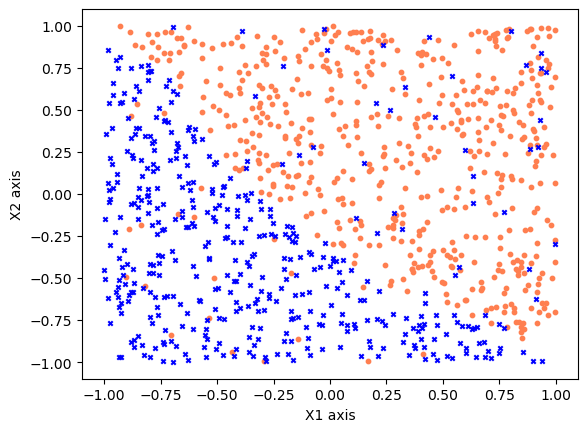

In [21]:
# data preprocessing

# visualize classified data
pos = np.where(y == 1)
neg = np.where(y == 0)
plt.scatter(X[pos, 0], 
            X[pos, 1], 
            color='coral', 
            marker='o', 
            s=10)
plt.scatter(X[neg, 0], 
            X[neg, 1], 
            color='blue', 
            marker='x', 
            s=10)
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

# randomize and split into train and test sets
ratio = 0.8
split_idx = int(len(X) * ratio)
rand_idx = np.random.permutation(len(X))
X = X[rand_idx]
y = y[rand_idx]
X_train, y_train = X[:split_idx, :], y[:split_idx]
X_test, y_test = X[split_idx:, :], y[split_idx:]

In [22]:
# evaluation

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

# algorithm for computing auc:
# 1. Sort:        sort true labels with predicted possibilities(from smallest to biggest)
# 2. FPR/TPR:     cumulatively sum up positive labels(1)/negtive labels(0) which refers to 
#                 width/height of every single square columns in auc
# 3. AUC Space:   from start(0) compute square column's space and sum up
def auc(y, y_pred):
    # sort the idx
    idx = np.argsort(y_pred)[::-1]
    y = y[idx]
    y_pred = y_pred[idx]
    # calculate FPR and TPR
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)
    tpr = tp / tp[-1]
    fpr = fp / fp[-1]
    # compute auc space
    s = 0.0
    tpr = np.concatenate([[0.0], tpr])
    fpr = np.concatenate([[0.0], fpr])
    for i in range(1, len(fpr)):
        s += (fpr[i] - fpr[i - 1]) * tpr[i]
    return s

def logistic(y_hat):
    return 1 / (1 + np.exp(-y_hat))

def loss_with_l2(y, y_hat, l2_coef, theta):
    return - y.T @ np.log(y_hat) - (1 - y).T @ np.log(1 - y_hat) + l2_coef * np.linalg.norm(theta) ** 2 / 2

def loss_without_l2(y, y_hat):
    return - y.T @ np.log(y_hat) - (1 - y).T @ np.log(1 - y_hat)

def optimize(X, y, y_hat, l2_coef, theta):
    return - X.T @ (y - y_hat) + l2_coef * theta

def logistic_regression(n_epochs, learning_rate, l2_coef):
    theta = np.random.normal(size=(X_train.shape[1],))
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    train_auc = []
    test_auc = []
    for i in range(n_epochs):
        # fit
        train_pred = logistic(X_train @ theta)
        test_pred = logistic(X_test @ theta)
        # loss
        train_loss = loss_with_l2(y_train, train_pred, l2_coef, theta)
        train_losses.append(train_loss / len(X_train))
        test_loss = loss_without_l2(y_test, test_pred)
        test_losses.append(test_loss / len(X_test))
        # optimize
        grad = optimize(X_train, y_train, train_pred, l2_coef, theta)
        theta -= grad * learning_rate
        # accuracy and auc
        train_accuracy.append(accuracy(y_train, train_pred>=0.5))
        test_accuracy.append(accuracy(y_test, test_pred>=0.5))
        train_auc.append(auc(y_train, train_pred))
        test_auc.append(auc(y_test, test_pred))
    return theta, train_losses, test_losses, train_accuracy, test_accuracy, train_auc, test_auc

# hyper parameters
n_epochs = 250
learning_rate = 0.002
l2_coef = 1.0
np.random.seed(0)

# 
X_train = np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
X_test = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)

# prediction
theta, train_losses, test_losses, train_accuracy, test_accuracy, train_auc, test_auc = logistic_regression(n_epochs, learning_rate, l2_coef)

predictions = np.where(logistic(X_test @ theta) >= 0.5, 1, 0) # theshold = 0.5
accuracies = accuracy(y_test, predictions)
print('accuracy: ', accuracies)
print('weights: ', theta)

accuracy:  0.875
weights:  [3.16460001 2.95976319 0.52490766]


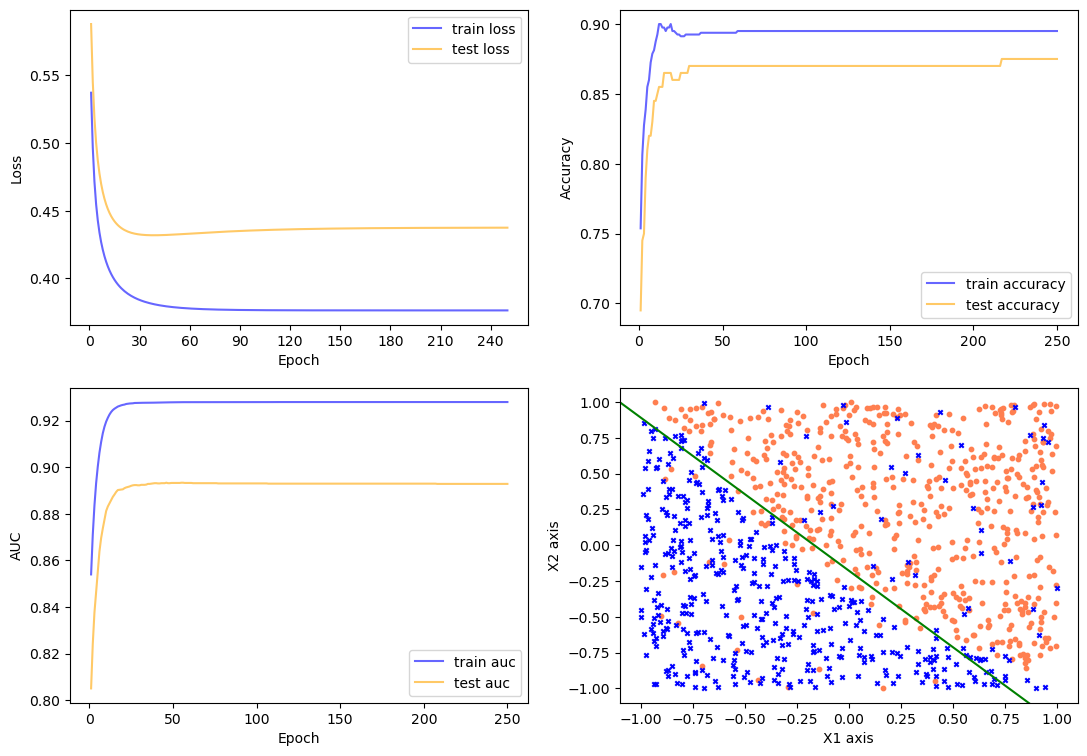

In [23]:
# visualization
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(13, 9))
xticks = np.arange(n_epochs) + 1

# loss figure
plt.subplot(221)
plt.plot(xticks, 
         train_losses, 
         color='blue', 
         label='train loss', 
         alpha=0.6)
plt.plot(xticks, 
         test_losses, 
         color='orange', 
         label='test loss', 
         alpha=0.6)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy figure
plt.subplot(222)
plt.plot(xticks, 
         train_accuracy, 
         color='blue', 
         label='train accuracy', 
         alpha=0.6)
plt.plot(xticks, 
         test_accuracy, 
         color='orange', 
         label='test accuracy', 
         alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# auc figure
plt.subplot(223)
plt.plot(xticks, 
         train_auc, 
         color='blue', 
         label='train auc', 
         alpha=0.6)
plt.plot(xticks, 
         test_auc, 
         color='orange', 
         label='test auc', 
         alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# segmentation figure
plt.subplot(224)
# scatter
pos = np.where(y == 1)
neg = np.where(y == 0)
plt.scatter(X[pos, 0], 
            X[pos, 1], 
            color='coral', 
            marker='o', 
            s=10)
plt.scatter(X[neg, 0], 
            X[neg, 1], 
            color='blue', 
            marker='x', 
            s=10)
# plot the segmentation curve
plot_x = np.linspace(-1.1, 1.1, 100)
plot_y = - (theta[0] * plot_x + theta[2]) / theta[1]
plt.plot(plot_x, 
         plot_y, 
         linestyle='-', 
         color='green')
plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

In [24]:
# Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print('accuracy: ', np.mean(y_test == pred))
print('weights: ', lr.coef_[0], lr.intercept_)

accuracy:  0.87
weights:  [3.1695657  2.96475834 0.26410929] [0.26410929]
